<a href="https://colab.research.google.com/github/Eduard953/Image_Processing_SS20/blob/master/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Processing SS 20 - Assignment - 02**
**Eduard Beiline, Bernard Breljak**

# Exercise 1 - 10 Points

In [0]:
# display the plots inside the notebook
%matplotlib inline

In [0]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pylab
import math
pylab.rcParams['figure.figsize'] = (12, 12)   # This makes the plot bigger

In [0]:
# imports
from skimage.data import astronaut
from skimage.color import rgb2gray

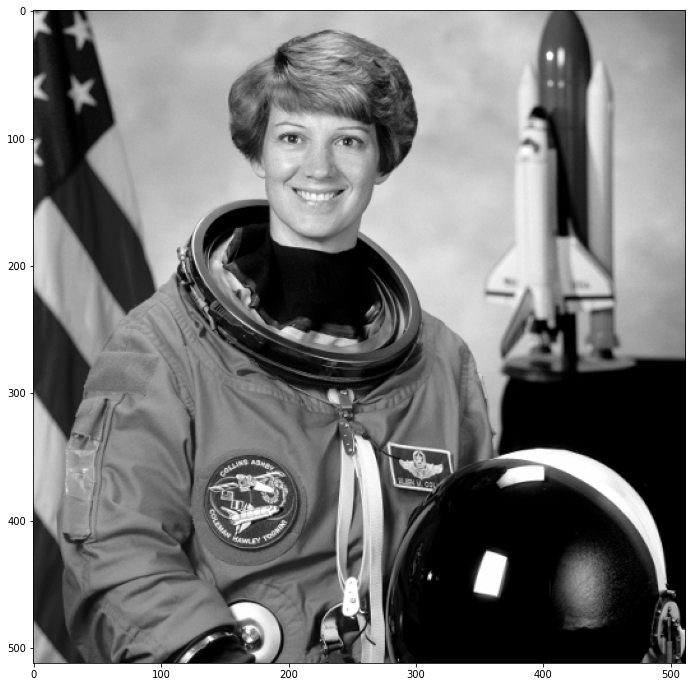

In [4]:
# We use a gray image. All the algorithms should work with color images too.
img = rgb2gray(astronaut() / 255.)
plt.imshow(img, cmap='gray')
plt.show()

In [0]:
def derive_y(image):
    """Computes the derivative of the image w.r.t the y coordinate"""
    derived_image = np.zeros_like(image)
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            if y + 1 < image.shape[1] and y - 1 > 0:
                derived_image[x,y] = image[x, y - 1] - image[x, y + 1]
    return derived_image

def derive_x(image):
    """Computes the derivative of the image w.r.t the x coordinate"""
    derived_image = np.zeros_like(image)
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            if x + 1 < image.shape[1] and x - 1 > 0:
                derived_image[x,y] = image[x - 1, y] - image[x + 1, y]
    return derived_image

In [0]:
dx_img = derive_x(img)
dy_img = derive_y(img)

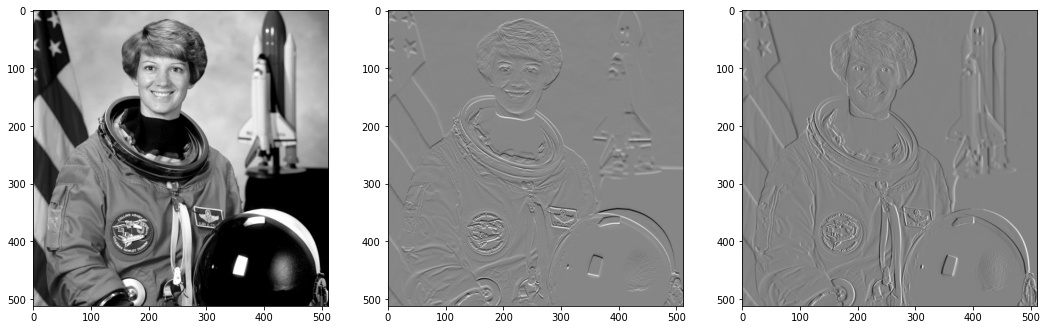

In [7]:
plt.figure(figsize=(18, 12))
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.subplot(132)
plt.imshow(dx_img, cmap='gray')
plt.subplot(133)
plt.imshow(dy_img, cmap='gray')
plt.show()

In [0]:

T_scale = np.array([
    [0.75, 0, 0],
    [0, 0.75, 0],
    [0, 0, 1],
])



In [0]:
T_affine = np.array([
    [1, 0.3, 0],
    [0, 1, 0],
    [0, 0, 1],
])

In [0]:
# inverted matrix of alpha

M = np.array([
        [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [-3,  3,  0,  0, -2, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2, -2,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0, -3,  3,  0,  0, -2, -1,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  2, -2,  0,  0,  1,  1,  0,  0],
        [-3,  0,  3,  0,  0,  0,  0,  0, -2,  0, -1,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0, -3,  0,  3,  0,  0,  0,  0,  0, -2,  0, -1,  0],
        [ 9, -9, -9,  9,  6,  3, -6, -3,  6, -6,  3, -3,  4,  2,  2,  1],
        [-6,  6,  6, -6, -3, -3,  3,  3, -4,  4, -2,  2, -2, -2, -1, -1],
        [ 2,  0, -2,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  2,  0, -2,  0,  0,  0,  0,  0,  1,  0,  1,  0],
        [-6,  6,  6, -6, -4, -2,  4,  2, -3,  3, -3,  3, -2, -1, -2, -1],
        [ 4, -4, -4,  4,  2,  2, -2, -2,  2, -2,  2, -2,  1,  1,  1,  1]
    ])

In [0]:
#perform affine transofrmation

def affine_transformation(img, matrix):

  # gets size 

  height, width = img.shape[:2]

  # create empty image of same size as img

  new_img = np.zeros_like(img)

  # reshape & stack indicies

  coords = np.indices((width, height)).reshape(2, -1)
  new_coords = np.vstack((coords, np.ones(coords.shape[1]))).astype(np.int)
  # get new coords

  x1, y1 = new_coords[0], new_coords[1]

  new_coords = np.round(matrix@new_coords).astype(np.int)
  x2, y2 = new_coords[0, :], new_coords[1, :]

  indices = np.where((x2 >= 0) & (x2 < width) &
                   (y2 >= 0) & (y2 < height))

  # appy new coords in image

  xpix2, ypix2 = x2[indices], y2[indices]
  xpix1, ypix1 = x1[indices], y1[indices]

  new_img[ypix2, xpix2] = img[ypix1, xpix1]
  img = new_img 


  return img, coords


In [0]:
# perform cubic interpolation

def bicubic_interpolation(img, indicies, matrix):
  dx_img = derive_x(img)
  dy_img = derive_y(img)
  dxy_img = derive_x(dy_img)

  x_size, y_size = img.shape
    
  # create empty image of same size as img

  new_image = np.zeros_like(img)
  extracted_indicies = np.linalg.inv(matrix) @ (np.concatenate([(np.indices(new_image.shape).reshape(2, -1)), np.ones((1, (np.indices(new_image.shape).reshape(2, -1)).shape[1]))], axis=0))

  # algorithm from  https://en.wikipedia.org/wiki/Bicubic_interpolation
  for i in range(extracted_indicies.shape[1]):

    #find the indicies of the 16 pixels in matrices for calculation

    dot = extracted_indicies[:, i]
    a1, a2, b1, b2 = int(np.floor(dot[0])), int(np.ceil(dot[0])), int(np.floor(dot[1])), int(np.ceil(dot[1]))

    #calculate the value of indicies of pixels in matrices

    if a1 < x_size and a1 > 0 and a2 < x_size and a2 > 0 and b1 < y_size and b1 > 0 and  b2 < y_size and b2 > 0:
      derivate_values = np.array([img[a1, b1], img[a2, b1], img[a1, b2], img[a2, b2],dx_img[a1, b1], dx_img[a2, b1], dx_img[a1, b2], dx_img[a2, b2], dy_img[a1, b1], dy_img[a2, b1], dy_img[a1, b2], dy_img[a2, b2],dxy_img[a1, b1], dxy_img[a2, b1], dxy_img[a1, b2], dxy_img[a2, b2]])
      func = M @ derivate_values
      new_image[int(np.rint((matrix @ dot)[0]))][int(np.rint((matrix @ dot)[1]))] = func[0] + func[4] * (dot[1] - b1) +  func[8] * (dot[1] - b1) ** 2 + func[12] * (dot[1] - b1) ** 3 + (func[1] + func[5] * (dot[1] - b1) +  func[9] * (dot[1] - b1) ** 2 + func[13] * (dot[1] - b1) ** 3) * (dot[0] - a1) + (func[2] + func[6] * (dot[1] - b1) + func[10] * (dot[1] - b1) ** 2 + func[14] * (dot[1] - b1) ** 3) * (dot[0] - a1) ** 2 + (func[3] + func[7] * (dot[1] - b1) + func[11] * (dot[1] - b1) ** 2 + func[15] * (dot[1] - b1) ** 3) * (dot[0] - a1) ** 3\

  return new_image

<function matplotlib.pyplot.imshow>

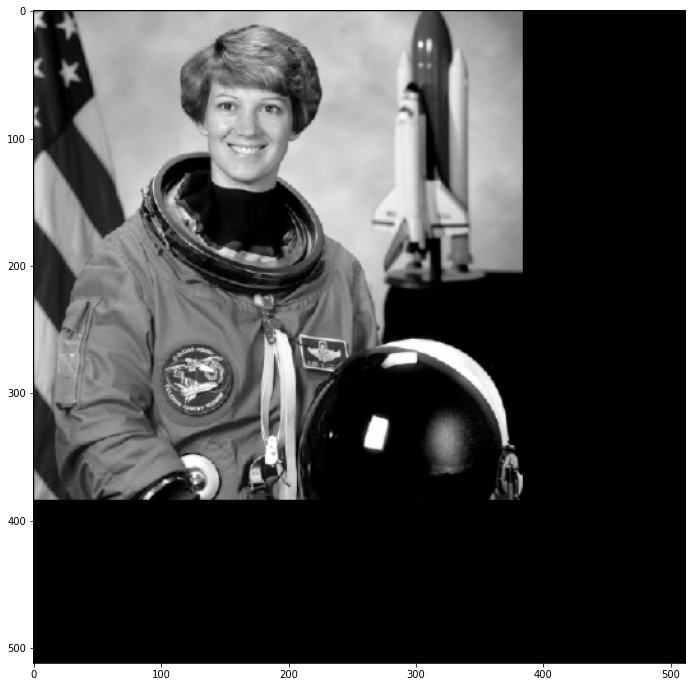

In [13]:
# plot T_scale
image_affine, indices_affine_transform = affine_transformation(img, T_scale)
affine_bicubic_image = (bicubic_interpolation(img, indices_affine_transform, T_scale))

plt.imshow(affine_bicubic_image, cmap='gray')
plt.imshow

<function matplotlib.pyplot.imshow>

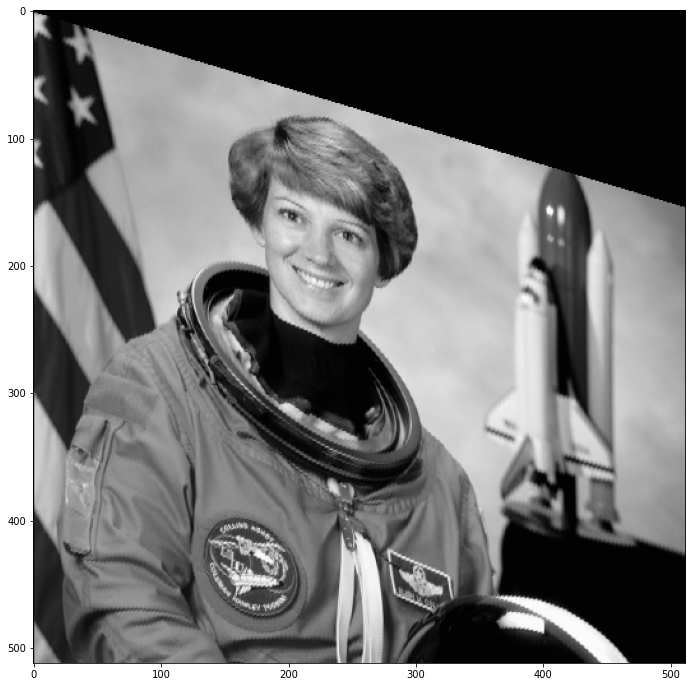

In [14]:
# plot T_affine
image_affine, indices_affine_transform = affine_transformation(img, T_affine)
affine_bicubic_image = (bicubic_interpolation(img, indices_affine_transform, T_affine))

plt.imshow(affine_bicubic_image, cmap='gray')
plt.imshow